# Understanding Bayesian Statistics with the On/Off Problem

Bayesian statistics is a sophisticated framework for inferring models from data. Here we will go over the basics of using Bayesian statistics in the context of the On/Off problem. While the On/Off problem applies to many situations, we will consider this an example of determining the signal in a noisy pixel from an astronomical image. We will see how one can set up a real inference problem with variables of interest, nuisance variables, and likelihood/prior models, then perform inference and run tests that everything is working properly. This tutorial can serve as a template from which to build a Bayesian inference in real scientific problems.

In [1]:
# Get our dependencies if you need them
# !pip install emcee corner tqdm tarp deprecation dynesty pted

In [2]:
from copy import copy
import math

import numpy as np
%matplotlib inline
#%matplotlib notebook
# import shutil
import matplotlib
import matplotlib.pyplot as plt
plt.xkcd()
plt.rcParams['font.family'] = 'Humor Sans'
from scipy.integrate import quad
from scipy.special import gamma, comb
from scipy.stats import truncnorm
import emcee
from corner import corner
from tqdm import tqdm
import tarp
from dynesty import NestedSampler
from pted import pted

colours = ["k","#FCE233", "#FC8565"]

## Bayesian vs. Frequentist

First, let's get through some basic philosophy, and define how each framework thinks about the word "probability"

**Frequentism:** probabilities are assigned to outcomes. Given a model of the world, one can determine the probability of an event ocurring. The statement "probability of a model" has no meaning since it is not an event. The meaning of a probability is the frequency of an event occuring if one were to re-run the "experiment" many times.

**Bayesian:** Probability is a degree of belief. One may assign probabilities to events or to models, really to anything that can be described mathematically. Before any experiment one has a "prior" belief and new data updates this belief by providing information (entropy) about the world. The statement "uninformative prior" has no meaning since the prior always influences the belief.

**trade-offs:** In frequentism it's easy to intepret the meaning of a probability since they have restricted it to the very concrete statement of "*frequency of events*". However the tradeoff is that the final implication for an experiment, measurement, decision is a bit contorted. you may hear the phrase "*we fail to reject the null hypothesis that the data is generated by X model*" which is a wordy way to say "*we think X is the right model*", but it's an important nuance in frequentism that is taken very seriously. In Bayesian statistics they have a much harder time giving a concrete definition of what the probabilities represent (besides the mystical "*degree of belief*"). However, the final result is often quite straightforward "*model X has Y probability*" since they may assign a probability to a model.

Ultimately, some problems are just better suited for a frequentism or Bayesian statistics perspective so neither one is strictly better. If you want to guess the outcome of a dice roll, this is very straightforwardly a question of frequencies of events; however asking about the brightness of a star we are asking for a model and its probability. Looking purely at the math, Bayesianism is a superset of frequentist statistics so if you set the philosophy aside then you are always doing Bayesian statistics.

![frequentists_vs_bayesians.png](https://imgs.xkcd.com/comics/frequentists_vs_bayesians.png)

## The Math

### Bayes Theorem

It's embaressingly simple. If we notice that the $P(A\cap B)$ formula (i.e. the probability of both $A$ and $B$ ocurring) is equivalent to $P(B\cap A)$ then Bayes Theorem just falls out immediately.

$$P(A\cap B) = P(A|B)P(B)$$

$$P(B\cap A) = P(B|A)P(A)$$

$$P(A|B) = \frac{P(B|A)P(A)}{P(B)}$$

Mathematically, there's not much more depth there. It's so simple that really it's true in Frequentist statistics as well, just philosophically they choose not to apply it to models. If it's so simple, why all the "fighting" between camps, and why do I hear that Bayesian probabilities are generally harder computationally? I firmly believe that both schools are equally challenging computationally if you are doing things "right", meaning that you consider all variables to the best of your ability. A shortcut that is sometimes employed in frequentist statistics is to find the Maximum Likelihood, which is comparatively easy but not really the right thing to do even in a frequentist framework. In a bBayesian framework it is very obvious that some integrals will be need, let's go over some of those integrals commonly used in Bayesian statistics next.

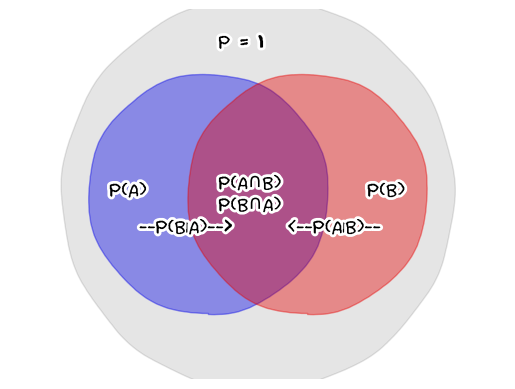

In [3]:
plt.scatter(
    [-0.5, 0.5, 0.0], [0, 0, 0], c=["b", "r", "k"], alpha=(0.4, 0.4, 0.1), s=(3e4, 3e4, 8e4)
)
plt.text(-1.5, 0, "P(A)")
plt.text(1.1, 0, "P(B)")
plt.text(-0.4, 2, "P = 1")
plt.text(-0.4, -0.2, "P(A$\\cap$B)\nP(B$\\cap$A)")
plt.text(-1.2, -0.5, "--P(B|A)-->")
plt.text(0.3, -0.5, "<--P(A|B)--")
plt.axis("off")
plt.xlim([-2.5, 2.5])
plt.ylim([-2.5, 2.5])
plt.show()

### Marginalization

There is generally a lot going on in a given experiment, most of it is variables or events you don't really care about. If you imagine that you have a very complex model described by a vector of variables $\theta$ which you want to know the PDF for (i.e. the magnitude of a star), and another vector $\phi$ which is needed to complete the model but which you don't really care about (i.e. you want the magnitude of a star, but you also need to know the sky level, the PSF, the magnitudes of nearby stars, read noise, gain, etc.). How do you drill down to just the $\theta$ variables you care about? The basic concept of marginalization can be written like this:

$$P(A) = \int P(A,B) dB = \int P(A|B)P(B)dB,$$

however, it is more useful when you consider a situation in which we have some data $X$ and a model $M$ to describe that data. Which after using Bayes theorem is written like this:

$$P(\theta|X,M) = \int \frac{P(X|\theta,\phi, M)P(\theta,\phi|M)}{P(X|M)}d\phi$$

This integral could be very complicated, consider that a real science problem may have dozens, hundreds, even many thousands of nuisance variables $\phi$, so how can we do this integral? Well, that's what this notebook is mostly about! Imagine if you could draw random samples from the PDF described by the integrand, a neat trick for marginalization when you've got samples is to simply drop all the variables you don't care about. Yes, that means the above integral can be done trivially if you have a sampling algorithm, the main challenge then is constructing a sampling algorithm which works in a reasonable amount of time.

![marginalization](https://upload.wikimedia.org/wikipedia/commons/8/8e/MultivariateNormal.png)

### Evidence

The evidence is the probability of some data given a model $P(X|M)$, in contrast the likelihood is the probability of some data given specific values in a model $P(X|\theta,M)$. Thus the evidence is an integral over all parameter space of the likelihood weighted by the prior. It looks something like this:

$$P(X|M) = \int P(X|\theta,M)P(\theta|M)d\theta$$

Essentially this is marginalization over all parameters. Note, that we have kept everything conditioned on the model $M$, which is operationally irrelevant for this expression, but we left it in to naturally segway into the next section about Bayes factors.

![modified_bayes_theorem.png](https://imgs.xkcd.com/comics/modified_bayes_theorem.png)

### Bayes Factor

If we have two models and we would like to determine which one better explains the data, a common technique is the Bayes Factor, which is a ratio of the evidence:

$$B = \frac{P(X|M_2)}{P(X|M_1)}$$

Which identifies the model that has assigned more probability density to the available data. If we think of probability as a finite resource (your model only has "1" probability to give out to all possible data "X") then the Bayes factor tells you which model made a bigger "bet" on the data that you happen to have gathered, at the expense of other possible "X"'s that could have been measured. The model which does this seems like a good bet for the better model since it took a gamble and won. For example, a "flat" model that treats every point in a large parameter space equally may be able to comfortably explain any datapoint, but if another model concentrates it's probability in a tight gaussian then any data outside that gaussian region would be very surprising to that model. If we happen to collect data that lands inside the tight gaussian, we should give it the win!

However, we can do a bit better. Let's use Bayes Theorem at the level of the models, where now we have a model $M$ which is the union of the two models $M_1,M_2$.

$$P(M_1|X) = \frac{P(X|M_1)P(M_1)}{P(X)}$$

$$P(X) = P(X|M_1)P(M_1) + P(X|M_2)P(M_2)$$

$$P(M_1|X) = \frac{1}{1 + \frac{P(X|M_2)P(M_2)}{P(X|M_1)P(M_1)}}$$

Thus, with the evidence we can use Bayes theorem to write the probability of a model given some data. Very useful! Note that you would typically assume $P(M_1)=P(M_2) = 0.5$ since you wouldn't test two models if you already thought one was way better. Meaning the probability of $M_1$ given some data can be represented entirely in terms of the Bayes factor:

$$P(M_1|X) = \frac{1}{1 + B}$$

The values of $B$ can be very large/small so representing them in log is often better. THus we can equally write:

$$P(M_1|X) = \frac{1}{1 + e^{\log(B)}}$$

Which anyone who does machine learning will recognise as the logistic function. Indeed the logistic function predictions are often considered probabilities and that's because it comes right from this probability expression!

![error_bars.png](https://imgs.xkcd.com/comics/error_bars.png)

## The On/Off Problem

Here is a classic problem in statistics and astronomy. Imagine we have a device which counts the number of events it experiences and is sensitive to some signal. Less cryptically, imagine a pixel in a telescope camera, this pixel will count the number of photons which hit it. There is a catch, however, that there is a certain amount of noise in the measurement where even if there is no signal we will still measure some number of counts (this is typically called dark current, read noise, sky, etc.). To combat this, we will make a measurement while the pixel is pointed at the source, and another measurement where the pixel is pointed at an empty part of the sky. This actually comes up in a number of other scenarios, such a geiger counters, medical tests, etc.

More concretely, here is our experimental setup:

- Unknown noise level: $n$
- Unknown signal level: $s$
- Measured counts on source: $N_{on}$
- Measured counts off source: $N_{off}$

We are essentially running two experiments, each of them is counting some number of photons. Since this is a counting problem, we can represent the probability distribution as a Poisson distribution:

$$P(N|\lambda) = \frac{\lambda^Ne^{-\lambda}}{N!}$$

where $\lambda$ is the rate of the signal (average number of counts) which is a positive real number and in our case is the $s$ and $n$ values, and $N$ is the measured number of counts which is a positive integer and in our case is the $N_{on}$ and $N_{off}$ values.

For the "on" signal experiment the total signal is $n+s$, so the likelihood looks like:

$$P(N_{on}|n,s) = \frac{(n+s)^{N_{on}}e^{-(n+s)}}{N_{on}!}$$

For the "off" signal experiment, the likelihood looks like:

$$P(N_{off}|n) = \frac{n^{N_{off}}e^{-n}}{N_{off}!}$$

Conveniently, the likelihood for both experiments is just the product of the individual likelihoods, since the two tests are independent of each other.

$$P(N_{on}, N_{off}|n,s) = P(N_{on}|n,s)P(N_{off}|n)$$

In our earlier language, the $N_{on},N_{off}$ counts are our data $X$, the signal $s$ is our variable of interest $\theta$, and the noise level $n$ is a nuisance parameter $\phi$.

In [4]:
# Lets define these likelihoods
PNon = lambda n, s, Non: (n + s) ** Non * np.exp(-n - s) / math.factorial(Non)
PNoff = lambda n, Noff: n**Noff * np.exp(-n) / math.factorial(Noff)
PNonNoff = lambda n, s, Non, Noff: PNon(n, s, Non) * PNoff(n, Noff)

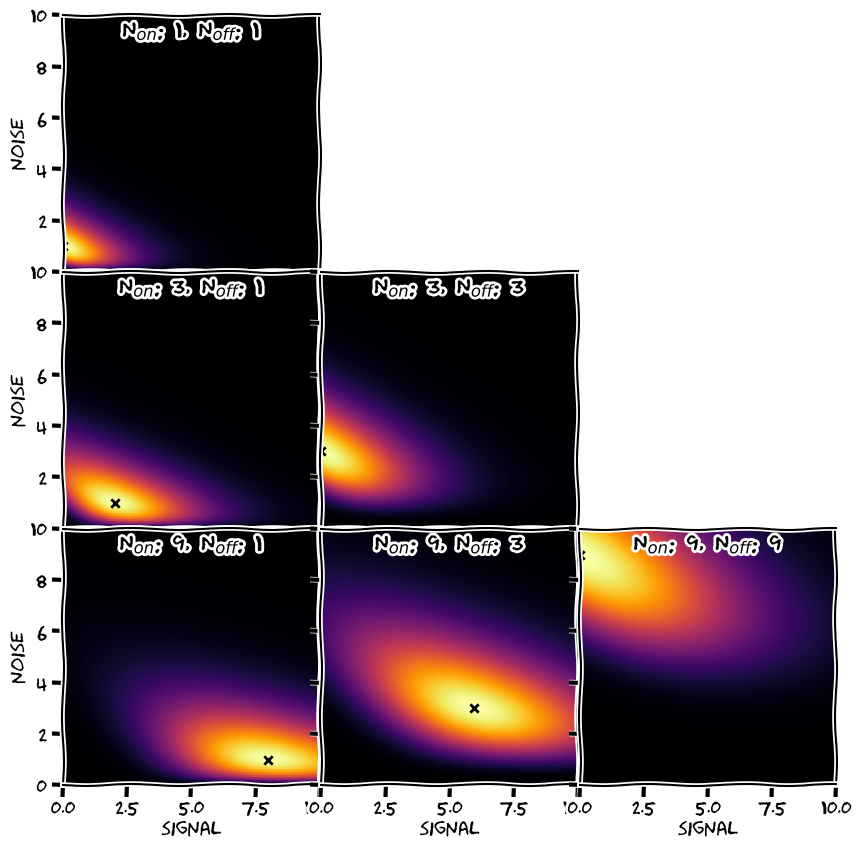

In [5]:
nx = np.linspace(0, 10, 100)
sx = np.linspace(0, 10, 100)
SS, NN = np.meshgrid(sx, nx)

fig, axarr = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.0, wspace=0.0)
for i, Non in enumerate((1, 3, 9)):
    for j, Noff in enumerate((1, 3, 9)):
        if i < j:
            axarr[i][j].axis("off")
            continue
        L = PNonNoff(NN, SS, Non, Noff)
        axarr[i][j].imshow(L, extent=(nx[0], nx[-1], sx[0], sx[-1]), origin="lower", cmap="inferno")
        Lmax = np.unravel_index(L.argmax(), L.shape)
        axarr[i][j].scatter(nx[Lmax[1]], sx[Lmax[0]], c="k", marker="x")
        axarr[i][j].set_title(f"N$_{{on}}$: {Non}, N$_{{off}}$: {Noff}", y=1, pad=-15)
        axarr[i][j].set_xlabel("signal")
        if j == 0:
            axarr[i][j].set_ylabel("noise")
plt.show()

FIG: Each sub-plot in this figure shows the likelihood distribution for a given $N_{on}, N_{off}$ scenario. The signal level is on the x-axis and the noise level is on the y-axis. We place a black "X" at the maximum likelihood point. The distributions are lopsided about the maximum, for low signal the likelihood spreads out to higher values, for high signal the likelihood spreads slightly to lower values. A similar effect is seen for the noise values.

![confounding_variables.png](https://www.explainxkcd.com/wiki/images/d/d9/confounding_variables.png)

### Analytic Marginalization

You wont be surprised to learn that the maximum likelihood signal level is $s = N_{on} - N_{off}$, and the maximum likelihood noise level is $n = N_{off}$. We can find this relatively easily by taking $\frac{\partial \log(P(N_{on},N_{off}|n,s))}{\partial s} = 0$ which will give $s = N_{on} - n$ and taking $\frac{\partial \log(P(N_{on},N_{off}|n,s))}{\partial n} = 0$ which will give $N_{off}(n+s) + N_{on}n = 2n(n+s)$. A bit of rearranging will recover the maximum likelihood.

This probabily aligns with your intuition. But looking at the full likelihood distributions, you may notice something a bit concerning, they all seem lopsided, not symmetric about the maximum likelihood. So I think you'll agree we can't just stop at finding the maximum likelihood, we should go further. We don't really care what the noise level is, the value of interest is the signal, so this is a case for marginalization! In this case it would look like this:

$$P(s|N_{on},N_{off}) = \frac{1}{P(N_{on},N_{off})}\int P(N_{on},N_{off}|n,s)P(n,s)dn$$

We use our prior $P(n,s)$ to impose a reasonable assumption that the signal and noise are positive, but beyond that for now we will assume the prior is flat. We could set a maximum at one billion just so that the prior density isn't technically $\frac{1}{\infty}$, but that is just being pedantic so we wont bother. We will also ignore $P(N_{on},N_{off})$ for now, since it only normalizes the probability density and we can do that manually. Writing everything out, it looks like this:

$$P(s|N_{on}, N_{off}) \propto \int_0^{\infty} \frac{(n+s)^{N_{on}}n^{N_{off}}e^{-2n-s}}{N_{on}!N_{off}!}dn$$

And in fact we can solve this analytically:

$$= \frac{e^{-s}}{N_{on}!N_{off}!}\int_0^{\infty} (n+s)^{N_{on}}e^{-2n}n^{N_{off}}dn$$

$$= \frac{e^{-s}}{N_{on}!N_{off}!}\int_0^{\infty} \sum_{k=0}^{N}\binom{N_{on}}{k}n^{k}s^{N_{on}-k}e^{-2n}n^{N_{off}}dn$$

$$= \frac{e^{-s}}{N_{on}!N_{off}!}\sum_{k=0}^{N}\binom{N_{on}}{k}s^{N_{on}-k}\int_0^{\infty}e^{-2n}n^{N_{off}+k}dn$$

$$= \frac{e^{-s}}{N_{on}!N_{off}!}\sum_{k=0}^{N}\binom{N_{on}}{k}\frac{s^{N_{on}-k}\Gamma(N_{off}+k+1)}{2^{N_{off}+k+1}}$$


In [6]:
def Ps_true(s, Non, Noff):
    res = 0
    for k in range(Non + 1):
        res += comb(Non, k) * s ** (Non - k) * gamma(Noff + k + 1) / 2 ** (Noff + k + 1)
    fact = np.exp(-s) / (math.factorial(Non) * math.factorial(Noff))
    return fact * res

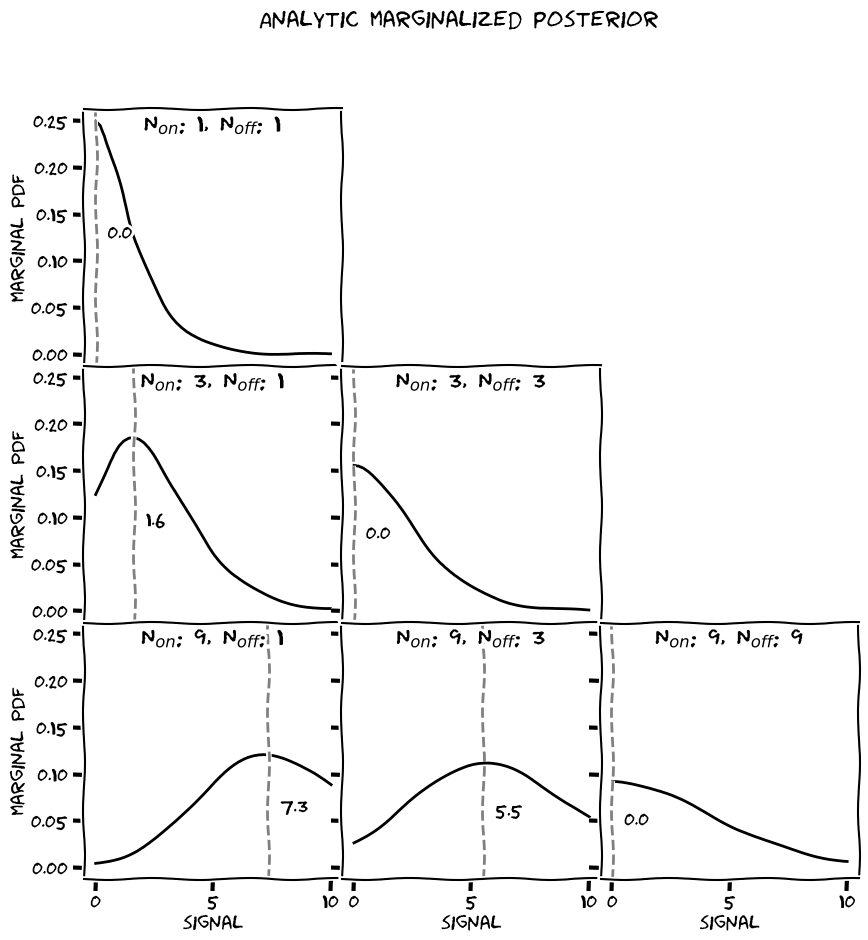

In [7]:
sx = np.linspace(0, 10, 50)
fig, axarr = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.0, wspace=0.0)
fig.suptitle("Analytic marginalized posterior")
for i, Non in enumerate((1, 3, 9)):
    for j, Noff in enumerate((1, 3, 9)):
        if i < j:
            axarr[i][j].axis("off")
            continue
        L = np.array(list(Ps_true(ssx, Non, Noff) for ssx in sx))
        axarr[i][j].plot(sx, L, c="k")
        Lmax = sx[L.argmax()]
        axarr[i][j].axvline(Lmax, c="grey", linestyle="--")
        axarr[i][j].set_title(f"N$_{{on}}$: {Non}, N$_{{off}}$: {Noff}", y=1, pad=-15)
        axarr[i][j].set_xlabel("signal")
        if j == 0:
            axarr[i][j].set_ylabel("marginal PDF")
        axarr[i][j].text(Lmax + 0.5, L.max() / 2, f"{Lmax:.1f}")
plt.show()

FIG: This figure is formatted somewhat like the previous figure to demonstrate the result for a number of $N_{on}, N_{off}$ combinations. Now the y-axis is the marginalized posterior density. Essentially for each value of $s$ we have integrated over all values of $n$. There is a vertical line at the MAP marginal signal level. Note that the MAP of the marginalized posterior is not always the same as the unmarginalized MAP.

![increased_risk.png](https://www.explainxkcd.com/wiki/images/1/11/increased_risk.png)

### Numerical Marginalization

Since this problem only has one dimension we wish to marginalize over, we can do it fairly easily by numerically integrating the posterior. We will use the scipy quad function which does gaussian quadrature integration and is very accurate.

In [8]:
Ps_num = lambda s, Non, Noff: quad(PNonNoff, 0, np.inf, args=(s, Non, Noff))[0]

**Side note: quad:** the function `scipy.integrate.quad` performs gaussian quadrature integration. Essentially it evaluates the function at a few points and uses a polynomial approximation to interpolate between them. Since a polynomial can be integrated analytically, they use that integral as an approximation of the real function. For gaussian quadrature in particular the polynomial approximation is especially clever, instead of fitting a polynomial, they select special points to evaluate the function such that they get the right integral for any polynomial up to a given order. It's worth learning more about, check out the wikipedia page here: https://en.wikipedia.org/wiki/Gaussian_quadrature

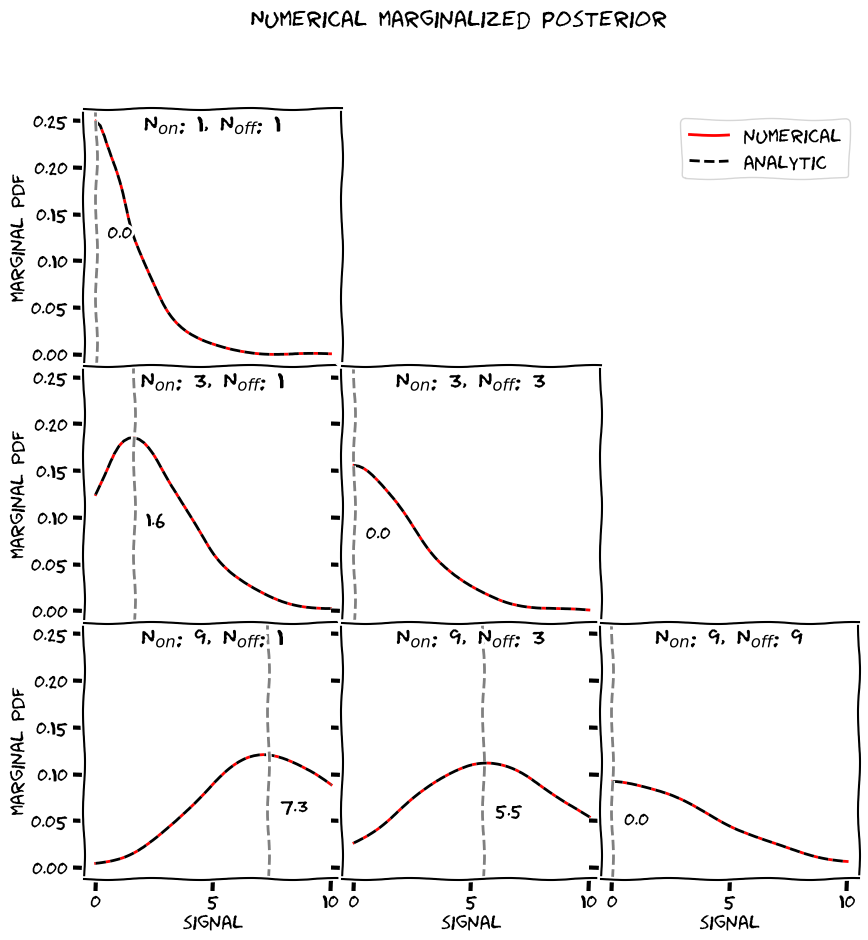

In [9]:
sx = np.linspace(0, 10, 50)
fig, axarr = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.0, wspace=0.0)
fig.suptitle("Numerical marginalized posterior")
for i, Non in enumerate((1, 3, 9)):
    for j, Noff in enumerate((1, 3, 9)):
        if i < j:
            axarr[i][j].axis("off")
            if i == 0 and j == 2:
                axarr[i][j].plot([], [], c="r", label="numerical")
                axarr[i][j].plot([], [], c="k", linestyle="--", label="analytic")
                axarr[i][j].legend()
            continue
        L = np.array(list(Ps_num(ssx, Non, Noff) for ssx in sx))
        L_true = np.array(list(Ps_true(ssx, Non, Noff) for ssx in sx))
        axarr[i][j].plot(sx, L, c="r")
        axarr[i][j].plot(sx, L_true, c="k", linestyle="--")
        Lmax = sx[L.argmax()]
        axarr[i][j].axvline(Lmax, c="grey", linestyle="--")
        axarr[i][j].set_title(f"N$_{{on}}$: {Non}, N$_{{off}}$: {Noff}", y=1, pad=-15)
        axarr[i][j].set_xlabel("signal")
        if j == 0:
            axarr[i][j].set_ylabel("marginal PDF")
        axarr[i][j].text(Lmax + 0.5, L.max() / 2, f"{Lmax:.1f}")
plt.show()

FIG: This figure is the same as above, except it also plots the marginalized posterior as computed numerically. There is no discernable difference between the two since the numerical approximation is extremely accurate in this domain.

![conditional_risk.png](https://www.explainxkcd.com/wiki/images/4/47/conditional_risk.png)

### Marginalize with MCMC sampling

If we can sample the full probability distribution, then we can marginalize by simply forgetting an axis we don't care about. There are lots of excellent sampling packages out there (e.g. emcee, Pyro), we will be using emcee which is easy to use and fast.

In [10]:
def logPns(sn, Non, Noff):
    if np.any(sn <= 0):
        return -np.inf
    return Non * np.log(sn[0] + sn[1]) - 2 * sn[1] - sn[0] + Noff * np.log(sn[1])


def Ps_MCMC(Non, Noff):
    sampler = emcee.EnsembleSampler(
        nwalkers=8,
        ndim=2,
        log_prob_fn=logPns,
        args=(Non, Noff),
    )
    p0 = np.clip(
        np.array((Noff, Non - Noff)) + np.random.uniform(-2, 2, (8, 2)), 1e-3, None
    )  # start at a good estimate
    # burn in
    state = sampler.run_mcmc(p0, 100)
    sampler.reset()
    # Full run
    state = sampler.run_mcmc(state, 2000)
    samples = sampler.get_chain(flat=True)
    return np.histogram(samples[:, 0], bins=25, range=(0, np.max(samples[:, 0])))

**Side note emcee:** the `emcee` package performs classic Markov-Chain Monte-Carlo sampling using the Metropolis Hastings algorithm. Essentially, starting from some point in the parameter space `emcee` will make a small random perturbation from that point. Using the probability density at the two points, it can use the Metropolis Hastings algorithm to either accept the random perturbation and move to the new spot, or reject it and stay at the current position. If you run this process long enough it is guaranteed to explore the whole probability density function, and the chain of parameter values it has explored will be distributed with the right probability distribution. Learn more here: https://emcee.readthedocs.io/en/stable/

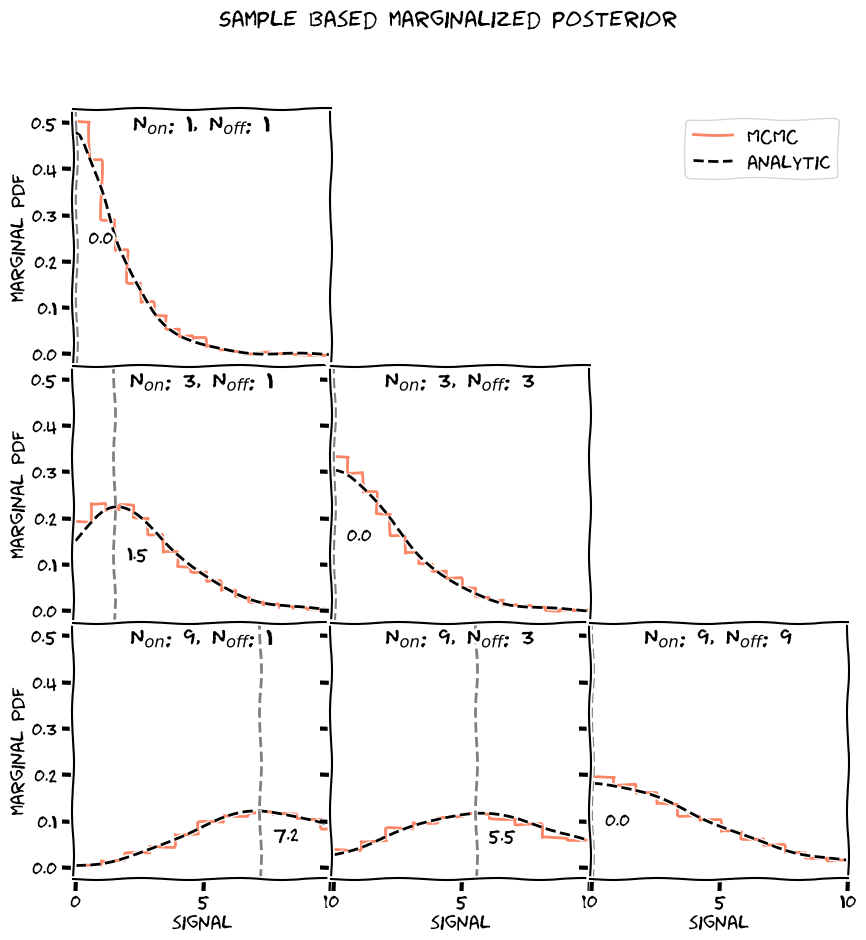

In [11]:
sx = np.linspace(0, 25, 150)
fig, axarr = plt.subplots(3, 3, figsize=(10, 10), sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.0, wspace=0.0)
fig.suptitle("Sample based marginalized posterior")
for i, Non in enumerate((1, 3, 9)):
    for j, Noff in enumerate((1, 3, 9)):
        if i < j:
            axarr[i][j].axis("off")
            if i == 0 and j == 2:
                axarr[i][j].plot([], [], c=colours[2], label="MCMC")
                axarr[i][j].plot([], [], c="k", linestyle="--", label="analytic")
                axarr[i][j].legend()
            continue
        L, sbin = Ps_MCMC(Non, Noff)
        width = sbin[1] - sbin[0]
        L = L / np.sum(L) / width
        axarr[i][j].step(sbin[:-1], L, where="post", color=colours[2])
        L_true = np.array(list(Ps_true(ssx, Non, Noff) for ssx in sx))
        L_true /= np.sum(L_true * (sx[1] - sx[0]))
        axarr[i][j].plot(sx, L_true, c="k", linestyle="--")
        Lmax = sx[L_true.argmax()]
        axarr[i][j].axvline(Lmax, c="grey", linestyle="--")
        axarr[i][j].set_title(f"N$_{{on}}$: {Non}, N$_{{off}}$: {Noff}", y=1, pad=-15)
        axarr[i][j].set_xlabel("signal")
        axarr[i][j].set_xlim([-0.1, 10])
        if j == 0:
            axarr[i][j].set_ylabel("marginal PDF")
        axarr[i][j].text(Lmax + 0.5, L_true.max() / 2, f"{Lmax:.1f}")
plt.show()

FIG: Same as the figure above, except now we plot the marginal posterior using the sampling method. Ultimately this just means sampling the full posterior distribution then only taking a histogram of the signal values. We can see that the sampling based marginal posterior is very accurate, but the randomness of the sampling process causes small deviations. Similarly, our choice of binning limits how smooth of a function we can approximate.

![statistics.png](https://www.explainxkcd.com/wiki/images/a/af/statistics.png)

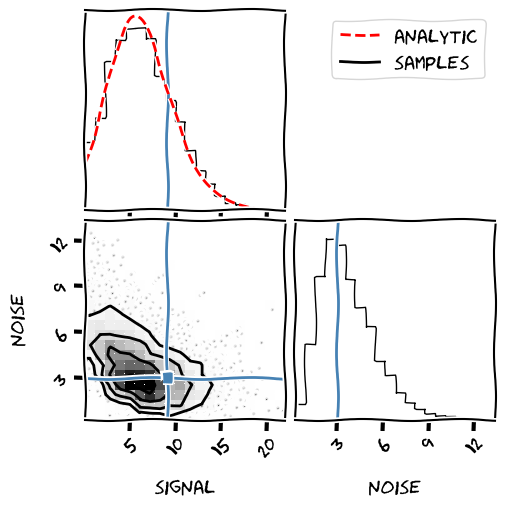

In [12]:
# This is what the marginalization looks like
Non = 9
Noff = 3
sampler = emcee.EnsembleSampler(
    nwalkers=8,
    ndim=2,
    log_prob_fn=logPns,
    args=(Non, Noff),
)
p0 = np.clip(
    np.array((Noff, Non - Noff)) + np.random.uniform(-2, 2, (8, 2)), 1e-3, None
)  # start at a good estimate
# burn in
state = sampler.run_mcmc(p0, 100)
sampler.reset()
# Full run
state = sampler.run_mcmc(state, 2000)
samples = sampler.get_chain(flat=True)
figure = corner(
    samples, labels=["signal", "noise"], hist_kwargs={"density": True}, truths=(Non, Noff)
)
axarr = figure.axes
sx = np.linspace(0, 25, 100)
L = np.array(list(Ps_true(ssx, Non, Noff) for ssx in sx))
L /= np.sum(L * (sx[1] - sx[0]))
axarr[0].plot(sx, L, c="r", linestyle="--", label="true")
axarr[1].plot([], [], c="r", linestyle="--", label="analytic")
axarr[1].plot([], [], c="k", linestyle="-", label="samples")
axarr[1].legend()
plt.show()

FIG: Here we plot a single example to show the marginalization process. In the lower left figure you see the sampling of the full posterior. The upper histogram and the right histogram show marginal posteriors accomplished by simply taking a histogram of only those values (signal and noise). We see how the analytic marginalized signal posterior matches with the samples fairly well.

**Side note corner:** The `corner` package is a neat little package for making plots like the one above, it will cleverly determine where to use a 2D histogram and where to simply plot the individual samples. It computes contours for the 1,2,3 sigma regions making it very convenient for plotting large collections of samples from an MCMC chain. learn more here: https://corner.readthedocs.io/en/latest/

## Posterior Sampling

If you can solve your problem analytically, or even numerically, then you are very lucky. There are many books filled with useful algorithms you can run to analyze your data. However, many interesting problems in Astronomy (and a lot of science) are so complex that sampling is really the only feasible way to tackle the problem. Going forward, we'll focus on sampling then, just know that if your problem can be solved numerically there is probably a scipy/numpy function out there that will do all this for you.

We have explored the concept of marginalization already and this has given us most of the tools we need to actually do posterior sampling. But we will re-phrase the problem again as a posterior sampling problem and introduce a more interesting prior to spice things up. Let's say now that we are looking at a particular class of objects that tend to have reliable brightnesses (imagine an RR Lyrae star) let's say from previous experiments we know that the brightness ($s$) is described by a gaussian with a mean of 10 and standard deviation of 3. Similarly, we calibrated our detector before running the experiment and we know that the noise rate on a given day is described by a gaussian with a mean of 3 and a standard deviation of 2. For both of them, we know that they can't be negative. So our priors look like this:

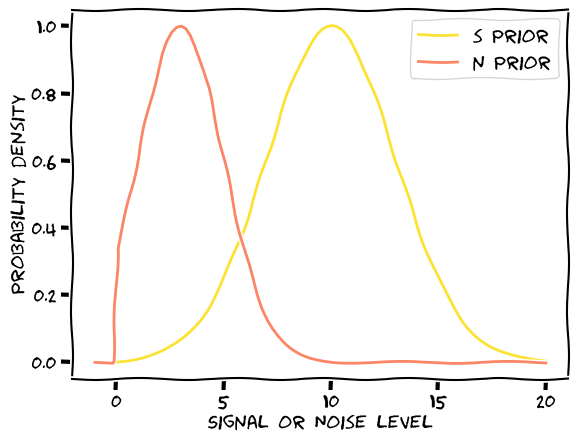

In [13]:
log_prior_s = lambda s: np.where(s <= 0, -np.inf, -0.5 * (s - 10) ** 2 / 3**2)
log_prior_n = lambda n: np.where(n <= 0, -np.inf, -0.5 * (n - 3) ** 2 / 2**2)
log_prior = lambda n, s: log_prior_n(n) + log_prior_s(s)

x = np.linspace(-1, 20, 100)

plt.plot(x, np.exp(log_prior_s(x)), c=colours[1], label="s Prior")
plt.plot(x, np.exp(log_prior_n(x)), c=colours[2], label="n Prior")
plt.ylabel("Probability density")
plt.xlabel("Signal or Noise level")
plt.legend()
plt.show()

FIG: Here we plot the priors to show what our previous knowledge indicates about the signal and noise levels we expect.

![confidence_interval.png](https://www.explainxkcd.com/wiki/images/1/19/confidence_interval.png)

Before getting into posterior sampling, lets make a function to draw samples from the prior distribution. We will assume for now that our prior is correct, so this is actually the distribution generating our data, but at any given point we are only looking at one object, and only get one measurement. So, for a given observation of an object we will draw an $s_{true}$ and a $n_{true}$, then to make the observation, we draw a sample from the corresponding poisson distributions to get the $N_{on}, N_{off}$ counts. It looks like this:

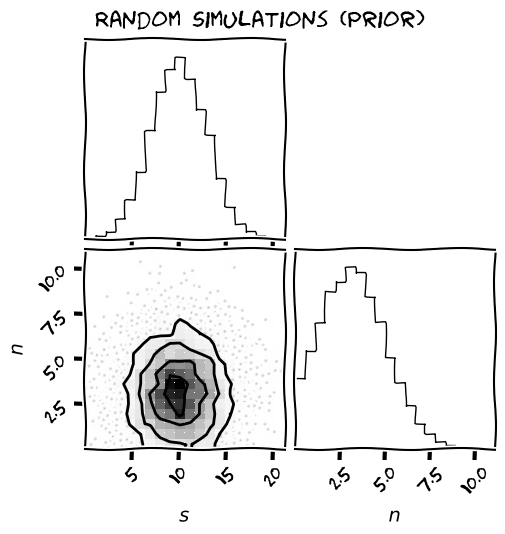

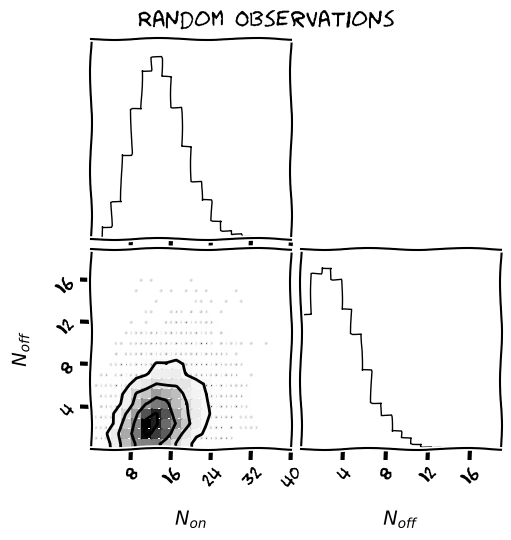

In [14]:
def draw_obs_ns():
    s = 0
    while s <= 0:
        s = np.random.normal(10, 3)
    n = 0
    while n <= 0:
        n = np.random.normal(3, 2)
    return n, s


def draw_obs_Nonoff(s=None, n=None):
    if s is None or n is None:
        n, s = draw_obs_ns()
    Noff = np.random.poisson(n)
    Non = np.random.poisson(n + s)
    return s, n, Non, Noff


track_N = []
for i in range(10000):
    track_N.append(draw_obs_Nonoff())
track_N = np.array(track_N)
figure = corner(track_N[:, :2], labels=["$s$", "$n$"])
figure.suptitle("Random Simulations (Prior)")
plt.show()

figure = corner(track_N[:, 2:], labels=["$N_{on}$", "$N_{off}$"])
figure.suptitle("Random Observations")
plt.show()
track_N = np.array(track_N[:, 2:], dtype=int)

FIG: The upper figure shows random signal ($s$) and noise ($n$) values drawn from our prior. Essentially these are the "stars" that we would like to observe. Note that the marginal distributions are exactly the same as the priors we assumed earlier.
The lower figure shows the corresponding counts for the measurements ($N_{on}, N_{off}$), which is what we actually see in our detector, that correspond to the upper figure signal/noise objects. Note that `corner` has some difficulty because these are integer values, instaed of real numbers like it expects.

In the marginalization section, the prior didn't play much of a role, except for limiting our integrals to the range $(0,\infty)$. Now the prior actually has a role to play in our posterior. Let's write out what the posterior looks like in our scenario:

$$P(n,s|N_{on}, N_{off}) = \frac{P(N_{on}, N_{off}|n,s)P(n,s)}{P(N_{on},N_{off})}$$

The likelihood ($P(N_{on}, N_{off}|n,s)$) is mostly what we explored before, the prior ($P(n,s)$) has just gotten more interesting, and the evidence ($P(N_{on},N_{off})$) will be a constant during a given experiment so we will continue to ignore it (for now, dun dun dun). To make our lives easier, we will focus on the log posterior, and only worry about terms that depend on our variables $n,s$ since the rest are just constants. This is what it looks like all together:

$$\log(P(n,s|N_{on}, N_{off}))+C = N_{on}\log(n+s) - 2n - s + N_{off}\log(n) + \log(\bar{\mathcal{N}}(s|10,3)) + \log(\bar{\mathcal{N}}(n|3,2))$$

where we are using $\bar{\mathcal{N}}$ to be a normal distribution truncated at 0.

In [15]:
log_likelihood = lambda n, s, Non, Noff: np.where(
    (n <= 0) | (s <= 0), -np.inf, Non * np.log(s + n) - 2 * n - s + Noff * np.log(n)
)
log_posterior = lambda n, s, Non, Noff: log_likelihood(n, s, Non, Noff) + log_prior(n, s)

/tmp/ipykernel_536582/2970367530.py:2: RuntimeWarning: invalid value encountered in log
  (n <= 0) | (s <= 0), -np.inf, Non * np.log(s + n) - 2 * n - s + Noff * np.log(n)


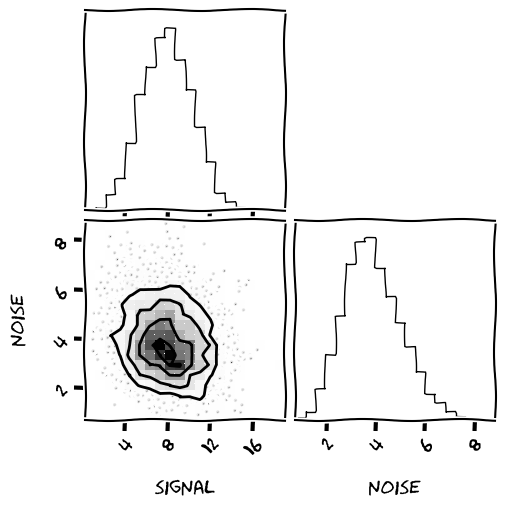

In [16]:
Non = 9
Noff = 5
sampler = emcee.EnsembleSampler(
    nwalkers=8,
    ndim=2,
    log_prob_fn=lambda x, Non, Noff: log_posterior(x[1], x[0], Non, Noff),
    args=(Non, Noff),
)
p0 = np.clip(
    np.array((Noff, Non - Noff)) + np.random.uniform(-2, 2, (8, 2)), 1e-3, None
)  # start at a good estimate
# burn in
state = sampler.run_mcmc(p0, 100)
sampler.reset()
# Full run
state = sampler.run_mcmc(state, 2000)
samples = sampler.get_chain(flat=True)
figure = corner(samples, labels=["signal", "noise"], hist_kwargs={"density": True})
plt.show()

FIG: This figure shows our posterior samples and the two marginal PDFs for a given $N_{on}, N_{off}$ combination. Which you will notice is actually a narrower distribution than before when we assumed flat priors.

Let's try a full simulated example, we'll draw the signal and noise values from our prior which will be the ground truth. Then we'll draw the $N_{on}, N_{off}$ samples using the poisson distribution. Finally we'll determine a posterior assuming we don't know the true $s,n$ values.

/tmp/ipykernel_536582/2970367530.py:2: RuntimeWarning: invalid value encountered in log
  (n <= 0) | (s <= 0), -np.inf, Non * np.log(s + n) - 2 * n - s + Noff * np.log(n)


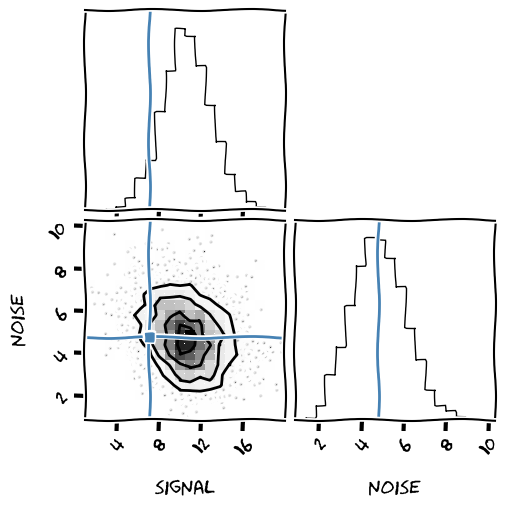

In [17]:
s_true, n_true, Non, Noff = draw_obs_Nonoff()

sampler = emcee.EnsembleSampler(
    nwalkers=8,
    ndim=2,
    log_prob_fn=lambda x, Non, Noff: log_posterior(x[1], x[0], Non, Noff),
    args=(Non, Noff),
)
p0 = np.clip(
    np.array((Noff, Non - Noff)) + np.random.uniform(-2, 2, (8, 2)), 1e-3, None
)  # start at a good estimate
# burn in
state = sampler.run_mcmc(p0, 100)
sampler.reset()
# Full run
state = sampler.run_mcmc(state, 2000)
samples = sampler.get_chain(flat=True)
figure = corner(
    samples, labels=["signal", "noise"], hist_kwargs={"density": True}, truths=(s_true, n_true)
)
plt.show()

FIG: Now we have plotted the posterior samples and marginal distributions. The true values for $s,n$ are given as lines which are plausibly included in the posterior (I hope, its random every time). Note that we have used a combination of our prior infomration and incoming data, we could have assumed flat priors to get the posterior, but then it would be wider. Let's see what that looks like

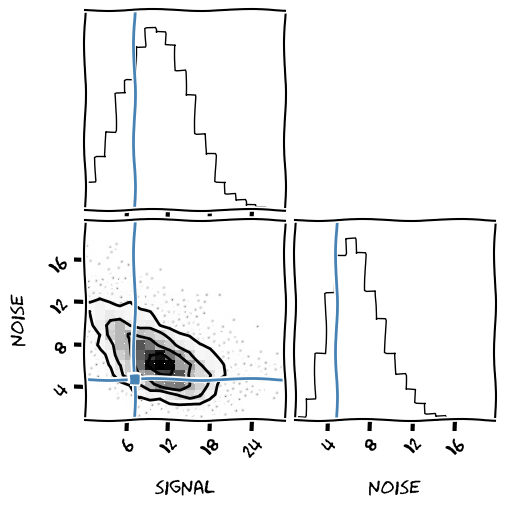

In [18]:
sampler = emcee.EnsembleSampler(
    nwalkers=8,
    ndim=2,
    log_prob_fn=logPns,
    args=(Non, Noff),
)
p0 = np.clip(
    np.array((Noff, Non - Noff)) + np.random.uniform(-2, 2, (8, 2)), 1e-3, None
)  # start at a good estimate
# burn in
state = sampler.run_mcmc(p0, 100)
sampler.reset()
# Full run
state = sampler.run_mcmc(state, 2000)
samples = sampler.get_chain(flat=True)
corner(samples, labels=["signal", "noise"], hist_kwargs={"density": True}, truths=(s_true, n_true))
plt.show()

FIG: Here we have computed the posterior for the same example as above, except assumed the flat priors from the beginning of the on/off example. Here we see that the posterior is much wider. This basically means that by not considering the prior we are leaving information on the table that could have been used!

![correlation.png](https://www.explainxkcd.com/wiki/images/9/9c/correlation.png)

### Coverage probability

Posterior sampling is great, but as Sandra Faber is known to say, "good scientists know their uncertainties, great scientists know the uncertinaty of their uncertainties". In real world posterior sampling scenarios things can get complicated, and we may have various numerical approximations along the way; so it's good to have a method to check that we are doing things properly. An excellent method is a coverage test, ultimately this is checking that when your posterior distribution says "there's a X% chance the true value is in this (a,b) range" then it's actually right. For us, we want to know that the signal $s$ and noise $n$ samples we draw for a given $N_{on}/N_{off}$ observation are properly distributed. Let's set that up and see how it goes!

In [19]:
# Create a bunch of simulations (mock observations where we know the true s and n values)
# We will run 250 simulations, each with 2 true values (s and n), we also record a mock observation for each simulation (Non and Noff)
simulations = []
for _ in range(250):
    simulations.append(draw_obs_Nonoff())
simulations = np.array(simulations)
simulations, observations = simulations[:, :2], simulations[:, 2:]

# For each simulation, run our sampling proceedure a bunch of times
# this will have the shape (number of posterior samples, number of simulations, number of dimensions) so thats (500, 250, 2)
samples = np.zeros((500, *simulations.shape))
for i, O in tqdm(list(enumerate(observations))):
    Non, Noff = O
    sampler = emcee.EnsembleSampler(
        nwalkers=16,
        ndim=2,
        log_prob_fn=lambda x, Non, Noff: log_posterior(x[1], x[0], Non, Noff),
        args=(Non, Noff),
    )
    p0 = np.clip(
        np.array((Noff, Non - Noff)) + np.random.uniform(-2, 2, (16, 2)), 1e-3, None
    )  # start at a good estimate
    # burn in
    state = sampler.run_mcmc(p0, 100)
    sampler.reset()
    # Full run
    state = sampler.run_mcmc(state, 500)
    subsamples = sampler.get_chain(flat=True)
    samples[:, i] = subsamples[::16]
ecp, alpha = tarp.get_tarp_coverage(samples, simulations)

  0%|          | 0/250 [00:00<?, ?it/s]

/tmp/ipykernel_536582/2970367530.py:2: RuntimeWarning: invalid value encountered in log
  (n <= 0) | (s <= 0), -np.inf, Non * np.log(s + n) - 2 * n - s + Noff * np.log(n)
100%|██████████| 250/250 [01:49<00:00,  2.29it/s]


**Side note TARP:** The `TARP` package stands for "Tests of Accuracy with Random Points" and it is built for computing coverage tests of posterior sampling proceedures when one only has samples to work with. By definition of coverage, any region which encloses X% of the psoterior samples, should enclose the true value at the same probability. So TARP takes in many simulaitons and samples as test points, then creates random regions of parameter space and checks how often the true value lands in those regions. Specifically, it takes a random point from the posterior sample, determines a hypersphere big enough to enclose the true value and checks how many other posterior samples are included in the hypersphere. Learn more about it here: https://ui.adsabs.harvard.edu/abs/2023PMLR..20219256L/abstract

**Side note tqdm:** the `tqdm` package just makes cool progress bars, it doesn't do any calculations. See more here: https://tqdm.github.io/

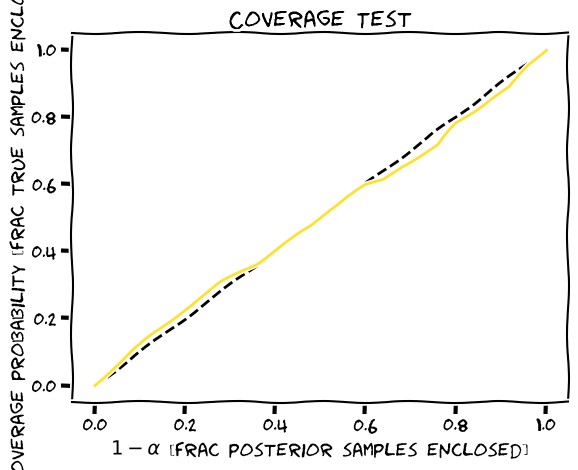

In [20]:
plt.plot([0, 1], [0, 1], linestyle="--", color="k")
plt.plot(alpha, ecp, color=colours[1])
plt.xlabel("$1 - \\alpha$ [frac posterior samples enclosed]")
plt.ylabel("coverage probability [frac true samples enclosed]")
plt.title("Coverage Test")
plt.show()

FIG: Which shows we are sampling perfectly! This means that any region we define which encloses 68% (1 sigma) of our samples, will also enclose the true value 68% of the time.

![error_types.png](https://www.explainxkcd.com/wiki/images/1/12/error_types.png)

### Evidence

We discussed evidence above, now let's see how we actually use it to test models. Let's say you're not yet sure about the prior distribution you've been using so far, so you'd like to test it against something more neutral. We create a second candidate prior where you just take a flat probability over the range in your observations to be very conservative. So we will say that $s$ can have any value from 0 to 40, and $n$ can have any value from 0 to 20. How can we check which model is right? This is a role for Bayesian evidence testing! Note that we are doing this entirely with the "data" ($N_{on}$ and $N_{off}$), not the true values so this works in real world scenarios!

Computing the evidence can be tricky, luckily there are very clever techniques to do it entirely from sampling. One of these methods is called Nested Sampling, for which there is a convenient package called "dynesty" that we can use.

In [21]:
log_prior_flat = lambda n, s: np.where((n <= 0) | (n > 20) | (s <= 0) | (s > 40), -np.inf, 0.0)
log_posterior_flat = lambda n, s, Non, Noff: log_likelihood(n, s, Non, Noff) + log_prior_flat(n, s)

In [22]:
def prior_transform_flat(u):
    return u * np.array((20, 40))


def prior_transform_true(u):
    return truncnorm.ppf(u, (-3 / 2, -10 / 3), (np.inf, np.inf), loc=(3, 10), scale=(2, 3))

In [23]:
s_true, n_true, Non, Noff = draw_obs_Nonoff()

# Compute the evidence for the true prior
sampler = NestedSampler(lambda x: log_likelihood(x[0], x[1], Non, Noff), prior_transform_true, 2)
sampler.run_nested()
levidence_true = sampler.results.logz[-1]
print(sampler.results.logz[-1])

# Compute the evidence for the flat prior
sampler = NestedSampler(lambda x: log_likelihood(x[0], x[1], Non, Noff), prior_transform_flat, 2)
sampler.run_nested()
levidence_flat = sampler.results.logz[-1]
print(sampler.results.logz[-1])

print("probability of flat prior: ", 1 / (1 + np.exp(levidence_true - levidence_flat)))

1024it [00:02, 472.72it/s, +500 | bound: 0 | nc: 1 | ncall: 4378 | eff(%): 39.299 | loglstar:   -inf < 14.376 <    inf | logz: 13.183 +/-    nan | dlogz:  0.001 >  0.509]


13.18326870913709


2226it [00:02, 888.50it/s, +500 | bound: 2 | nc: 1 | ncall: 19434 | eff(%): 14.397 | loglstar:   -inf < 14.377 <    inf | logz: 10.768 +/-  0.073 | dlogz:  0.001 >  0.509]

10.768383727034594
probability of flat prior:  0.08204466187875607


While it's possible for the flat prior to have a higher probability on some observations, the vast majority will favour the true prior! So you will very quickly realize that the prior we are using is better. Note that this isn't null hypothesis testing like in frequentism, this is an actual probability that one model is better than another. So we don't need an arbitrary limit like `p = 0.05` to reject the null, we can straightforwardly say, the probability of the flat model is only xx% (anything less than 50%) percent, so we go with the better prior model going forward, and we do so with exactly the confidence of that probability.

**Side note dynesty:** The `dynesty` package is built to perform Nested Sampling. This is a technique much like MCMC sampling with Metropolis Hastings (like `emcee`), except instead of generating random samples from a probability density function, it computes an integral of the evidence (see the math section at the top). It does this by randomly sampling from the Prior, and selecting points with progressively higher likelihood. By estimating the prior volume enclose by each region of all points with higher likelihood than a given point, it is possible to turn the many dimensional evidence integral into a 1D integral. Learn more here: https://dynesty.readthedocs.io/en/stable/

![selection_bias.png](https://www.explainxkcd.com/wiki/images/9/9b/selection_bias.png)

## Bonus: Two Sample Test with PTED

This is a null hypothesis test, where the null hypothesis is that the two samples are drawn from the same distribution. Check out the [README here](https://github.com/ConnorStoneAstro/pted). Essentially, PTED works by by taking distances for pairs of points within and between the two samples. By comparing those distances we can get something called the "Energy Distance", if we then randomly shuffle points between the two samples we create a situation where the null hypothesis is true. Computing the energy distance for many permutations we can determine how unusual the first energy distance with the unscrambled data was.

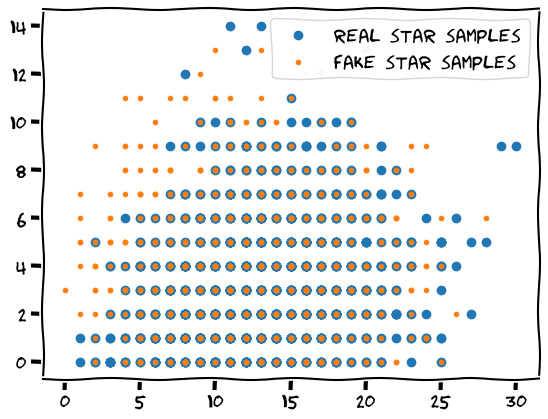

In [24]:
real_sample = []
for _ in range(1000):
    real_sample.append(draw_obs_Nonoff()[2:])
real_sample = np.array(real_sample)
plt.scatter(real_sample[:, 0], real_sample[:, 1], marker="o", label="real star samples")
fake_sample = []
while len(fake_sample) < 1000:
    sample = np.random.normal(loc=(13, 3), scale=(5, 3.5))
    if np.all(sample >= 0):
        fake_sample.append(sample.astype(int))
fake_sample = np.stack(fake_sample)
plt.scatter(fake_sample[:, 0], fake_sample[:, 1], marker=".", label="fake star samples")
plt.legend()
plt.show()

FIG: Here we see two hypothetical data samples, one actually comes from the objects we are modelling ("real star samples"), and the other comes from a hypothetical second sample which we aren't sure comes from the same distribution ("fake star samples"). While visually they are quite similar, PTED will detect their difference easily.

In [25]:
pvals = pted(fake_sample, real_sample)
print("P-value test: ", np.median(pvals))

P-value test:  0.000999000999000999


This p-value test clearly rejects the possibility that the two samples are the same.